In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from matplotlib import pyplot as plt
import sys
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from numpy.random import randn
from scipy.io import loadmat
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model,Sequential,Model
import math
import time
from tensorflow.keras.layers import Conv1D, MaxPooling1D,Lambda,Concatenate,Dropout
import pdb; 
import scipy
from keras.constraints import Constraint
from scipy.stats import truncnorm
from scipy.stats import weibull_min

In [ ]:
#Data Preprocessing Functions
def get_gencost(number_of_buses,mat_gen,mat_gencost):
  '''Function to format the generators' cost'''
  gen_ids = mat_gen[:,0]-1
  c1=np.zeros(number_of_buses)
  c2=np.zeros(number_of_buses)
  j=0
  for i in range(0,number_of_buses):
    if i in gen_ids:
      c1[i] = mat_gencost[j,5]
      c2[i] = mat_gencost[j,4]
      j=j+1
  tf_c1 = tf.convert_to_tensor(c1,dtype='float32')
  tf_c2 = tf.convert_to_tensor(c2,dtype='float32')
  return tf_c1,tf_c2

def get_pq_bound(number_of_buses, mat_gen):
  '''This is the function to get and format the upper and
     lower bound of active&reactive power at each buse'''
  number_of_gens = mat_gen.shape[0]
  p_upper = np.zeros(number_of_buses)
  q_upper = np.zeros(number_of_buses)
  q_lower = np.zeros(number_of_buses)
  j=0
  for i in range(0,number_of_buses):
    if i in (mat_gen[:,0]-1):
      #pdb.set_trace()
      p_upper[i]=mat_gen[j,8]
      q_upper[i]=mat_gen[j,3]
      q_lower[i]=mat_gen[j,4]
      j=j+1
  tf_p_upper = tf.convert_to_tensor(p_upper/baseMVA,dtype='float32')
  tf_q_upper = tf.convert_to_tensor(q_upper/baseMVA,dtype='float32')
  tf_q_lower = tf.convert_to_tensor(q_lower/baseMVA,dtype='float32')
  return tf_p_upper,tf_q_upper,tf_q_lower


def get_vm_va_bound(mat_load):
  '''
  #This is the function to get and format the upper and lower bound 
  #of voltage magnitude&angle at each buse
  '''
  vm_lower = mat_load['aa'][:,-1]
  vm_upper = mat_load['aa'][:,-2]
  #vm_lower[0]=1
  #vm_upper[0]=1
  va_lower = np.ones(118)*(-180)
  va_upper = np.ones(118)*(180)
  #va_lower[0]=0
  #va_upper[0]=0
  tf_vm_upper = tf.convert_to_tensor(vm_upper,dtype='float32')
  tf_vm_lower = tf.convert_to_tensor(vm_lower,dtype='float32')
  tf_va_upper = tf.convert_to_tensor(va_upper,dtype='float32')
  tf_va_lower = tf.convert_to_tensor(va_lower,dtype='float32')
  return tf_vm_upper,tf_vm_lower,tf_va_upper,tf_va_lower

def define_generator(latent_dim):
  '''#Defining model G'''
  code = keras.Input(shape=(1,1))
  random_noise = keras.Input(shape=(1,latent_dim))
  demand = keras.Input(shape=(1,118*2))
  concat_layer= Concatenate(axis=-1)([code,random_noise, demand])
  hidden = Conv1D(256, (1), activation=None,padding='same')(concat_layer)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  #hidden = Dropout(0.1)(hidden)
  hidden = Conv1D(128, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(64, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(32, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  #hidden = Dropout(0.1)(hidden)
  hidden = layers.Flatten()(hidden)
  g_active = layers.Dense(118,dtype='float32',activation='sigmoid')(hidden)
  g_active = tf.math.multiply(g_active,tf_p_upper)
  g_reactive = layers.Dense(118,dtype='float32',activation='sigmoid')(hidden)
  g_reactive = tf.math.multiply(g_reactive,tf_q_upper-tf_q_lower)\
                                                    +tf_q_lower
  bus_vm = layers.Dense(118,dtype='float32',activation='sigmoid')(hidden)
  bus_vm = tf.math.multiply(bus_vm,tf_vm_upper-tf_vm_lower)+tf_vm_lower
  bus_va = layers.Dense(118,dtype='float32',activation='sigmoid')(hidden)
  bus_va = tf.math.multiply(bus_va,tf_va_upper-tf_va_lower)+tf_va_lower
  g_model = keras.Model(inputs=[code,random_noise,demand], outputs=[g_active,g_reactive,bus_vm,bus_va])
  return g_model

def define_qnetwork():
  '''#Defining model Q'''
  g_active = keras.Input(shape=(1,118))
  hidden = Conv1D(4, (1), activation=None,padding='same')(g_active)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = layers.Flatten()(hidden)
  out_layer = layers.Dense(1,dtype='float32',activation='tanh')(hidden)
  q_model = Model(g_active, out_layer)
  return q_model

def define_gp_critic():
  '''#Defining model D'''
  demand = keras.Input(shape=(1,118*2))
  g_active = keras.Input(shape=(1,118))
  g_reactive = keras.Input(shape=(1,118))
  bus_vm = keras.Input(shape=(1,118))
  bus_va = keras.Input(shape=(1,118))
  concat_layer= Concatenate(axis=-1)([demand,g_active,g_reactive,bus_vm,bus_va])
  hidden = Conv1D(512, (3), activation=None,padding='same')(concat_layer)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = layers.MaxPooling1D(pool_size=(3),padding='same')(hidden)
  hidden = Conv1D(256, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden = Conv1D(128, (1), activation=None,padding='same')(hidden)
  hidden = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden)
  hidden1 = Conv1D(64, (1), activation=None,padding='same')(hidden)
  hidden1 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden1)
  hidden1 = Conv1D(32, (1), activation=None,padding='same')(hidden1)
  hidden1 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden1)
  hidden1 = Conv1D(16, (1), activation=None,padding='same')(hidden1)
  hidden1 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden1)
  hidden1 = Conv1D(8, (1), activation=None,padding='same')(hidden1)
  hidden1 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden1)
  hidden1 = layers.Flatten()(hidden1)
  hidden2 = Conv1D(64, (1), activation=None,padding='same')(hidden)
  hidden2 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden2)
  hidden2 = Conv1D(32, (1), activation=None,padding='same')(hidden2)
  hidden2 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden2)
  hidden2 = Conv1D(16, (1), activation=None,padding='same')(hidden2)
  hidden2 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden2)
  hidden2 = Conv1D(8, (1), activation=None,padding='same')(hidden2)
  hidden2 = tf.keras.layers.LeakyReLU(alpha=0.1)(hidden2)
  hidden2 = layers.Flatten()(hidden2)
  out_layer = layers.Dense(1,dtype='float32',activation=None)(hidden1)
  r_out_layer = layers.Dense(1,dtype='float32',activation=None)(hidden2)
  r1_out_layer = layers.Dense(1,dtype='float32',activation=None)(hidden2)
  #define model
  d_model = Model([demand,g_active,g_reactive,bus_vm,bus_va], [out_layer,r_out_layer,r1_out_layer])
  return d_model


def define_gan(g_model, d_model):
  '''# define the combined generator and discriminator model, for updating the generator'''
  # make weights in the discriminator not trainable
  d_model.trainable = False
  [g_active,g_reactive,bus_vm,bus_va] = generator.output
  [gen_code, gen_noise, gen_label] = generator.input
  gan_output = d_model([tf.reshape(gen_label,[-1,1,118*2]),tf.reshape(g_active,[-1,1,118]),\
                        tf.reshape(g_reactive,[-1,1,118]),tf.reshape(bus_vm,[-1,1,118]),\
                        tf.reshape(bus_va,[-1,1,118])])
  # define gan model as taking noise and label and outputting a classification
  model = Model([gen_code, gen_noise, gen_label], gan_output)
  return model

def define_ae(g_model,q_model):
  '''# define the combined generator and Q model, for updating the generator'''
  [g_active,g_reactive,bus_vm,bus_va] = g_model.output
  [gen_code, gen_noise, gen_label] = g_model.input
  q_output = q_model(tf.reshape(g_active,[-1,1,118]))
  ae_model = Model([gen_code, gen_noise, gen_label], q_output)
  return ae_model

def rdm_load_pq_20per(case_pload,case_qload,sample_number):
  '''Sampling Demand in +- 20 percent'''
  number_of_bus = case_pload.shape[0]
  p_demand = np.zeros([sample_number,number_of_bus])
  q_demand = np.zeros([sample_number,number_of_bus])
  for i in range(0,number_of_bus):
    pi = case_pload[i]
    qi = case_qload[i]
    if case_pload[i]!=0:
      p_mw = np.random.uniform(pi*0.8,pi*1.2,sample_number)
      q_mvar = np.random.uniform(qi*0.8,qi*1.2,sample_number)
      p_demand[:,i] = p_mw
      q_demand[:,i] = q_mvar
  return p_demand,q_demand

def generate_latent_points(latent_dim, n_samples):
  '''generate_latent_points'''
  # generate points in the latent space
  code_input = np.random.uniform(-1,1,n_samples).reshape([n_samples,1])
  x_input = randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  # generate labels
  p_demand,q_demand = rdm_load_pq_20per(case118_pload,case118_qload,n_samples)
  labels = np.concatenate([p_demand,q_demand],axis=1)
  return [code_input,z_input, labels]

# select real samples
def generate_real_samples(n_samples):
  '''generate_real_points'''
  # choose random instances
  ix = np.random.randint(0, real_conditions.shape[0], n_samples)
  # select images and labels
  batch_condition,batch_vm,batch_va,batch_p,batch_q = real_conditions[ix], \
    real_vm[ix], real_va[ix], real_p[ix], real_q[ix]
  # generate class labels
  y = -np.ones((n_samples, 1))
  return batch_condition,batch_vm,batch_va,batch_p,batch_q, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
  '''generate fake samples'''
	# generate points in latent space
	c_input, z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([c_input, z_input, labels_input])
	# create class labels
	y = np.ones((n_samples, 1))
	return c_input, labels_input,images, y

def feasibility_checking(p_demand,q_demand, active_p,reactive_q,vm,va):
  '''Check the physical power balance violations'''
  generated_size = p_demand.shape[0]
  #Step1: calculate power withdraw on each bus
  P_out = tf.convert_to_tensor(p_demand-active_p,dtype='float32')
  Q_out = tf.convert_to_tensor(q_demand-reactive_q,dtype='float32')
  #pdb.set_trace()
  #get voltage on each bus
  v_r = tf.math.multiply(vm,tf.cos(tf.math.multiply(va,tf.constant(math.pi/180,dtype='float32'))))
  v_i = tf.math.multiply(vm,tf.sin(tf.math.multiply(va,tf.constant(math.pi/180,dtype='float32'))))
  V = tf.reshape(tf.complex(v_r,v_i),[generated_size,118])

  #calculate current
  Y_bus_tf = tf.convert_to_tensor(Y_bus)
  I = tf.matmul(V,Y_bus_tf)

  #calculate power injection on each bus
  S_in = tf.math.multiply(V,tf.math.conj(I))
  P_in = tf.math.real(S_in)
  Q_in = tf.math.imag(S_in)

  #evaluate the balance
  p_balance = tf.reduce_mean(P_in+P_out,axis=0)
  q_balance = tf.reduce_mean(Q_in+Q_out,axis=0)
  return p_balance,q_balance


def generate_test_samples(generator, latent_dim, test_samples):
  '''# use the generator to generate n fake examples, with class labels'''
  # generate points in latent space
  n_samples = opf_real_conditions_validation.shape[0]
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  # predict outputs
  images = generator.predict([z_input, opf_real_conditions_validation])
  # create class labels
  y = np.ones((n_samples, 1))
  return opf_real_conditions_validation,images, y

def optimality_checking(p_opt,q_opt,p_fake,q_fake):
  '''Checking the financial optimality'''
  p_mse = K.mean(K.square(p_opt-p_fake))
  q_mse = K.mean(K.square(q_opt-q_fake))
  return p_mse,q_mse

In [ ]:
'''
#This is the block to load data from matlab, and cvs dataset
#Then process them ready for the neural network training
'''
#Load grid data from matlab
mat_y = loadmat('Y_bus118.mat')
mat_gen = loadmat('IEEE118_gen.mat')['gen118']
mat_load = loadmat('IEEE118_load.mat')
mat_gencost = loadmat('case118_gencost.mat')['gencost']

#Load dataset
condition_part1 = loadmat('grid118_fc_conditions_by_opf.mat')['conditions_list']
solution_part1 = loadmat('grid118_fc_points_by_opf.mat')['datapoints_list']
line_constraints = loadmat('grid118_line_constraints.mat')['line_constraint']
condition_part2 = loadmat('grid118_fc_conditions1_by_opf.mat')['conditions_list']
solution_part2 = loadmat('grid118_fc_points1_by_opf.mat')['datapoints_list']

#Data preprocessing
Y_bus = mat_y['Y_bus118'].toarray().astype('complex64')
baseMVA = 100
case118_pload = mat_load['aa'][:,2]/baseMVA
case118_qload = mat_load['aa'][:,3]/baseMVA
real_conditions = np.concatenate([condition_part1,condition_part2],axis=0)/baseMVA
real_points = np.concatenate([solution_part1,solution_part2],axis=0)
real_vm = real_points[:,0:118]
real_va = real_points[:,118:236]
matpower_p = real_points[:,236:290]
matpower_q = real_points[:,290:]
real_p = np.zeros(real_vm.shape)
real_q = np.zeros(real_vm.shape)
gen_ids = mat_gen[:,0]-1
j=0
for i in range(0,118):
  if i in gen_ids:
    real_p[:,i]=matpower_p[:,j]
    real_q[:,i]=matpower_q[:,j]
    j=j+1
real_p=real_p/baseMVA
real_q = real_q/baseMVA

tf_p_upper,tf_q_upper,tf_q_lower = get_pq_bound(118, mat_gen)
tf_vm_upper,tf_vm_lower,tf_va_upper,tf_va_lower = get_vm_va_bound(mat_load)
tf_c1,tf_c2 = get_gencost(118,mat_gen,mat_gencost)

gen_id=mat_gen[:,0]-1
non_gen_ids = np.zeros([64])
j=0
for i in range(0,118):
  if i not in gen_id:
    non_gen_ids[j]=i
    j=j+1
wind_der_ids = non_gen_ids[:-40]
solar_der_ids = non_gen_ids[-40:]

line_constraints.shape
from_buses = line_constraints[:,1]-1
to_buses = line_constraints[:,2]-1
s_max = line_constraints[:,4]

constraint_matrix = np.zeros([118,118])
i=0
for fb in from_buses:
  constraint_matrix[int(fb),int(to_buses[i])]=s_max[i]
  i=i+1

In [ ]:
tf_c1,tf_c2=get_gencost(118,mat_gen,mat_gencost)
cost1=tf.math.multiply(real_p*baseMVA, tf_c1)
cost2=tf.math.multiply(K.square(tf.cast(real_p*baseMVA,tf.float32)), tf_c2)
suma = tf.reduce_sum(cost1+cost2,axis=1)
print(min(suma))
plt.hist(suma.numpy(),bins=100)
plt.title(' Distribution of Cost Values')
plt.xlabel('Cost Values (dollars)')
plt.ylabel('Number of Points')

In [ ]:
iterations = 10000
n_critic=10
n_q = 1
best_pb=0.2
best_qb=0.2
number_of_buses=118
lbd=10
mu=10
delta=100
nu=1000
xi=10
latent_dim = 200
batch_size = 512
half_batch = batch_size//2
discriminator = define_gp_critic()
generator =define_generator(latent_dim)
qnetwork = define_qnetwork()
gan_model = define_gan(generator, discriminator)
ae_model = define_ae(generator,qnetwork)
loss_d1_list = []
loss_d2_list = []
loss_g_list = []                                                                              
real_acc_list = []
fake_acc_list = []
dy_dx_list=[]
pbalance_list=[]
qbalance_list=[]
opt_perr_list=[]
opt_qerr_list=[]
ae_loss_list=[]
gp_list=[]
physics_loss_list=[]
regression_list = []
branch_loss_list = []
r2_loss_list = []

for i in range(iterations):
  with tf.GradientTape(persistent=True) as tape:
    discriminator.trainable=True
    #pdb.set_trace()
    #Initializing optimizers:
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    q_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    r_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)
    
    '''
      Block 1 starts: Training the discriminator for $n_critic times
    '''
    for _j in range(n_critic):
      #Prepare real and fake data
      real_batch_demand, real_batch_vm,real_batch_va,real_batch_p,real_batch_q, \
                  real_batch_y = generate_real_samples(half_batch)
      [fake_latent_code, fake_latent_noise, _] = \
                  generate_latent_points(latent_dim, half_batch)
      [fake_batch_p,fake_batch_q,fake_batch_vm,fake_batch_va] = \
                  generator([tf.reshape(fake_latent_code,[-1,1,1]),\
                  tf.reshape(fake_latent_noise,[-1,1,latent_dim]),\
                  tf.reshape(real_batch_demand,[-1,1,118*2])])
      fake_batch_y = np.ones((half_batch, 1))
      alpha = K.random_uniform(
          shape=[half_batch,1], 
          minval=0.,
          maxval=1.
      )
      diff_batch_vm = real_batch_vm - fake_batch_vm
      diff_batch_va = real_batch_va - fake_batch_va
      diff_batch_p = real_batch_p - fake_batch_p
      diff_batch_q = real_batch_q - fake_batch_q

      inter_batch_vm = real_batch_vm + (alpha*diff_batch_vm)
      inter_batch_va = real_batch_va + (alpha*diff_batch_va)
      inter_batch_p = real_batch_p + (alpha*diff_batch_p)
      inter_batch_q = real_batch_q + (alpha*diff_batch_q)

      '''
      Calculate the Cost function for discriminator
      '''
      #Prepare the gradient penalty
      inter_d_output,_,_ = discriminator([tf.reshape(real_batch_demand,[-1,1,118*2]),\
                                tf.reshape(inter_batch_p,[-1,1,118]),\
                                tf.reshape(inter_batch_q,[-1,1,118]),\
                                tf.reshape(inter_batch_vm,[-1,1,118]),\
                                tf.reshape(inter_batch_va,[-1,1,118])])
      inter_gradients_p = tape.gradient(inter_d_output, [inter_batch_p,inter_batch_q,inter_batch_vm,inter_batch_va])
      rdc_sum = tf.math.reduce_sum(tf.math.reduce_sum(tf.square(inter_gradients_p),axis=0),axis=1)
      slopes = K.sqrt(rdc_sum)
      gradient_penalty = tf.reduce_mean(tf.square((slopes-1.)))
      
      #calculate the regular WGAN loss
      real_d_output,_,_ = discriminator([tf.reshape(real_batch_demand,[-1,1,118*2]),\
                                            tf.reshape(real_batch_p,[-1,1,118]),\
                                            tf.reshape(real_batch_q,[-1,1,118]),\
                                            tf.reshape(real_batch_vm,[-1,1,118]),\
                                            tf.reshape(real_batch_va,[-1,1,118])])
      fake_d_output,_,_ = discriminator([tf.reshape(real_batch_demand,[-1,1,118*2]),\
                                            tf.reshape(fake_batch_p,[-1,1,118]),\
                                            tf.reshape(fake_batch_q,[-1,1,118]),\
                                            tf.reshape(fake_batch_vm,[-1,1,118]),\
                                            tf.reshape(fake_batch_va,[-1,1,118])])
      d1_loss = K.mean(real_d_output*real_batch_y)
      loss_d1_list.append(d1_loss.numpy())
      d2_loss = K.mean(fake_d_output*fake_batch_y)
      loss_d2_list.append(d2_loss.numpy())
      gp_list.append(gradient_penalty.numpy())
      d_loss = d1_loss+d2_loss+delta*gradient_penalty
      
      #-----------Model R-------------
      #Step0: Select some real data
      if _j%n_critic==0:
        real_data_num_for_r = 3
        downnsample_batch_demand, downnsample_real_batch_vm,downnsample_real_batch_va,\
        downnsample_real_batch_p,downnsample_real_batch_q,downnsample_real_batch_y \
        = generate_real_samples(real_data_num_for_r)
        r_batch_demand = tf.concat([real_batch_demand,downnsample_batch_demand],axis=0)
        r_batch_vm = tf.concat([fake_batch_vm,downnsample_real_batch_vm],axis=0)
        r_batch_va = tf.concat([fake_batch_va,downnsample_real_batch_va],axis=0)
        r_batch_p = tf.concat([fake_batch_p,downnsample_real_batch_p],axis=0)
        r_batch_q = tf.concat([fake_batch_q,downnsample_real_batch_q],axis=0)
        #Step1: calculate power withdraw on each bus

        PQ_out = tf.convert_to_tensor(tf.dtypes.cast(r_batch_demand, tf.float32)-tf.concat([r_batch_p,\
                                                                      r_batch_q],axis=1),dtype='float32')
        
        #get voltage on each bus
        v_r = tf.math.multiply(r_batch_vm,tf.cos(tf.math.multiply(r_batch_va,\
                                                                    tf.constant(math.pi/180,dtype='float32'))))
        v_i = tf.math.multiply(r_batch_vm,tf.sin(tf.math.multiply(r_batch_va,\
                                                                    tf.constant(math.pi/180,dtype='float32'))))
        V = tf.reshape(tf.complex(v_r,v_i),[-1,number_of_buses])

        #calculate current
        Y_bus_tf = tf.convert_to_tensor(Y_bus)
        I = tf.matmul(V,Y_bus_tf)

        #calculate power injection on each bus
        S_in = tf.math.multiply(V,tf.math.conj(I))
        P_in = tf.math.real(S_in)
        Q_in = tf.math.imag(S_in)
        #pdb.set_trace()
        #evaluate the balance
        PQ_balance = tf.concat([P_in,Q_in],axis=1)+PQ_out
        mean_PQ_balance = tf.reshape(tf.reduce_mean(K.abs(PQ_balance),axis=1),[-1,1])
        
        _,r_output,r2_output = discriminator([tf.reshape(r_batch_demand,[-1,1,118*2]),\
                                            tf.reshape(r_batch_p,[-1,1,118]),\
                                            tf.reshape(r_batch_q,[-1,1,118]),\
                                            tf.reshape(r_batch_vm,[-1,1,118]),\
                                            tf.reshape(r_batch_va,[-1,1,118])])
        r_loss = tf.reduce_mean(K.square(mean_PQ_balance-r_output))

        v_r = tf.math.multiply(fake_batch_vm,tf.cos(tf.math.multiply(fake_batch_va,\
                                                                 tf.constant(math.pi/180,dtype='float32'))))
        v_i = tf.math.multiply(fake_batch_vm,tf.sin(tf.math.multiply(fake_batch_va,\
                                                                    tf.constant(math.pi/180,dtype='float32'))))
        fake_v = tf.reshape(tf.complex(v_r,v_i),[-1,number_of_buses])
        V_ij_conjugate=tf.math.conj(tf.reshape(fake_v,[-1,118,1])-tf.reshape(fake_v,[-1,1,118]))
        V_Vij_conjugate = tf.multiply(tf.reshape(fake_v,[-1,118,1]),V_ij_conjugate)
        broad_Ybus = tf.reshape(Y_bus_tf,[1,118,118])
        flow = tf.multiply(V_Vij_conjugate,tf.math.conj(broad_Ybus*(-1)))
        flow_norm = K.sqrt(K.square(tf.math.real(flow)*100)+K.square(tf.math.imag(flow)*100))
        branch_flow_loss = tf.reduce_mean(tf.nn.relu(flow_norm-constraint_matrix))
        r2_loss = tf.reduce_mean(K.square(branch_flow_loss-r2_output))
        #pdb.set_trace()
        d_grads = tape.gradient(d_loss+xi*(r_loss+r2_loss),discriminator.trainable_weights)
        d_optimizer.apply_gradients(zip(d_grads+d_grads, discriminator.trainable_weights))
        #r_optimizer.apply_gradients(zip(r_grads, discriminator.trainable_weights))
        regression_list.append(r_loss)
        r2_loss_list.append(r2_loss)
    '''
      Block 1 ends.
    '''
    
    '''
      Block 2 starts: Training the generator
    '''
    #Train Generator 
    full_real_batch_demand,_,_,_,_,_ = generate_real_samples(batch_size)
    [fake_latent_code, fake_latent_noise, _] = \
                  generate_latent_points(latent_dim, batch_size)
    tf_fake_batch_demand = tf.keras.backend.variable(full_real_batch_demand)
    tape.watch(tf_fake_batch_demand)
    [fake_batch_p,fake_batch_q,fake_batch_vm,fake_batch_va] = \
                        generator([tf.reshape(fake_latent_code,[-1,1,1]),\
                        tf.reshape(fake_latent_noise,[-1,1,latent_dim]),\
                        tf.reshape(tf_fake_batch_demand,[-1,1,number_of_buses*2])])
    fake_gan_output,_,_ = discriminator([tf.reshape(tf_fake_batch_demand,[-1,1,number_of_buses*2]),\
                                            tf.reshape(fake_batch_p,[-1,1,number_of_buses]),\
                                            tf.reshape(fake_batch_q,[-1,1,number_of_buses]),\
                                            tf.reshape(fake_batch_vm,[-1,1,number_of_buses]),\
                                            tf.reshape(fake_batch_va,[-1,1,number_of_buses])])
    fake_batch_y = -np.ones((batch_size, 1))
    gan_loss = K.mean(fake_gan_output*fake_batch_y)
    dy_dx = tf.reduce_mean(tf.square(tape.gradient([fake_batch_p,fake_batch_q,\
                                                    fake_batch_vm,fake_batch_va],\
                                                    tf_fake_batch_demand)))
    
    #-----------physics
    #Step1: calculate power withdraw on each bus
    PQ_out = tf.convert_to_tensor(tf_fake_batch_demand-tf.concat([fake_batch_p,\
                                                                  fake_batch_q],axis=1),dtype='float32')
    
    #get voltage on each bus
    v_r = tf.math.multiply(fake_batch_vm,tf.cos(tf.math.multiply(fake_batch_va,\
                                                                 tf.constant(math.pi/180,dtype='float32'))))
    v_i = tf.math.multiply(fake_batch_vm,tf.sin(tf.math.multiply(fake_batch_va,\
                                                                 tf.constant(math.pi/180,dtype='float32'))))
    V = tf.reshape(tf.complex(v_r,v_i),[-1,number_of_buses])

    #calculate current
    Y_bus_tf = tf.convert_to_tensor(Y_bus)
    I = tf.matmul(V,Y_bus_tf)
    #calculate power injection on each bus
    S_in = tf.math.multiply(V,tf.math.conj(I))
    P_in = tf.math.real(S_in)
    Q_in = tf.math.imag(S_in)
    #pdb.set_trace()
    #evaluate the balance
    PQ_balance = tf.concat([P_in,Q_in],axis=1)+PQ_out
    mean_PQ_balance = tf.reduce_mean(K.square(PQ_balance))
    physics_loss_list.append(mean_PQ_balance)

    #calculate current
    #pdb.set_trace()
    V_ij_conjugate=tf.math.conj(tf.reshape(V,[-1,118,1])-tf.reshape(V,[-1,1,118]))
    V_Vij_conjugate = tf.multiply(tf.reshape(V,[-1,118,1]),V_ij_conjugate)
    broad_Ybus = tf.reshape(Y_bus_tf,[1,118,118])
    flow = tf.multiply(V_Vij_conjugate,tf.math.conj(broad_Ybus*(-1)))
    flow_norm = K.sqrt(K.square(tf.math.real(flow)*100)+K.square(tf.math.imag(flow)*100))
    branch_flow_loss = tf.reduce_mean(tf.nn.relu(flow_norm-constraint_matrix))
    #p_balance = tf.reduce_mean(P_in+P_out,axis=0)
    #q_balance = tf.reduce_mean(Q_in+Q_out,axis=0)
    #-----------
    print('branch_loss: '+str(branch_flow_loss))
    branch_loss_list.append(branch_flow_loss)
    
    loss_g_list.append(gan_loss.numpy())
    dy_dx_list.append(dy_dx.numpy())
    discriminator.trainable=False
    gan_grads = tape.gradient(gan_loss+lbd*dy_dx+mu*(mean_PQ_balance+branch_flow_loss),gan_model.trainable_weights)
    g_optimizer.apply_gradients(zip(gan_grads, gan_model.trainable_weights))
  
    #Training the Q Inference Network
    for _k in range(n_q):
      q_output = qnetwork(tf.reshape(fake_batch_p,[-1,1,118]))
      q_loss = nu*K.mean(K.square(fake_latent_code-q_output))
      ae_loss_list.append(q_loss.numpy())
      ae_grads = tape.gradient(q_loss, ae_model.trainable_weights)
      q_optimizer.apply_gradients(zip(ae_grads, ae_model.trainable_weights))
    '''
      Block 2 ends.
    '''

    print('This is the iter '+str(i)+', the d1 loss is: '+str(d1_loss.numpy())+\
          ', the d2 loss is: '+str(d2_loss.numpy())+\
          ', the g loss is: '+str(gan_loss.numpy())+\
          ', the ae loss is: '+str(q_loss.numpy())+\
          ', the pq loss is: '+str(mean_PQ_balance.numpy())+\
          ', the jacobian loss is:'+str(dy_dx.numpy())+\
          ', the r loss is:'+str(r_loss.numpy())+\
          ', the r2 loss is'+str(r2_loss.numpy()))
  if i%100==0:
    generated_size = 1001
    c_input, z_input, opf_real_conditions_validation = generate_latent_points(latent_dim, generated_size)
    [fake_p,fake_q,fake_vm,fake_va] = generator.predict([c_input.reshape([-1,1,1]), z_input.reshape([-1,1,latent_dim]),\
                                                         opf_real_conditions.reshape([-1,1,118*2])])
    # create class labels
    y_fake = np.ones((generated_size, 1))
    pb,qb=feasibility_checking(opf_real_conditions[0:6000,0:118],opf_real_conditions[0:6000,118:], fake_p,fake_q,fake_vm,fake_va)
    pbalance_list.append(K.mean(abs(pb)).numpy())
    qbalance_list.append(K.mean(abs(qb)).numpy())
    print(K.mean(abs(pb)).numpy())
    print(K.mean(abs(qb)).numpy())

In [ ]:
generator.save('g.h5')
discriminator.save('dd.h5')
qnetwork.save('q.h5')

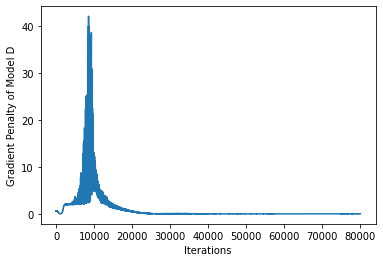

In [ ]:
plt.plot(gp_list[:])
plt.xlabel('Iterations')
plt.ylabel('Gradient Penalty of Model D')
plt.show()

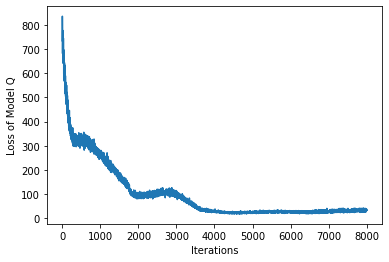

In [ ]:
plt.plot(ae_loss_list[:])
plt.xlabel('Iterations')
plt.ylabel('Loss of Model Q')
plt.show()

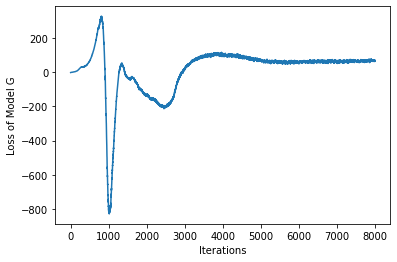

In [ ]:
plt.plot(loss_g_list[:])
plt.xlabel('Iterations')
plt.ylabel('Loss of Model G')
plt.show()

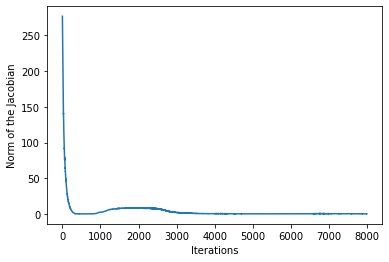

In [ ]:
plt.plot(dy_dx_list[:])
plt.xlabel('Iterations')
plt.ylabel('Norm of the Jacobian')
plt.show()

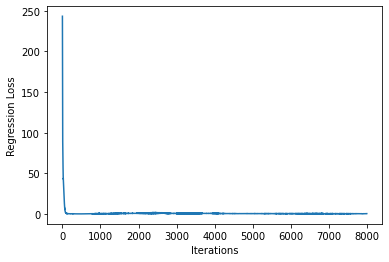

In [ ]:
plt.plot(regression_list)
plt.xlabel('Iterations')
plt.ylabel('Regression Loss')
plt.show()

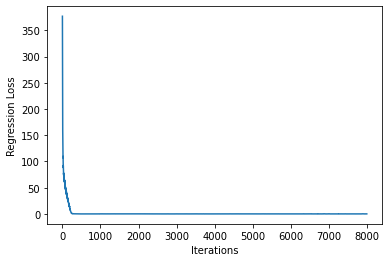

In [ ]:
plt.plot(r2_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Regression Loss')
plt.show()

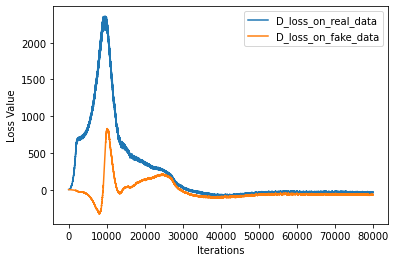

In [ ]:
#plt.plot(loss_g_list)
lst = np.array(loss_d1_list)
plt.plot(list(-lst))
plt.plot(loss_d2_list)
plt.legend(['D_loss_on_real_data','D_loss_on_fake_data'])
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.show()

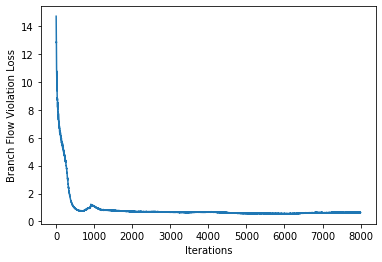

In [ ]:
#plt.plot(loss_g_list)
lst = np.array(loss_d1_list)
plt.plot(branch_loss_list)
#plt.plot(loss_d2_list)
#plt.legend(['D_loss_on_real_data','D_loss_on_fake_data'])
plt.xlabel('Iterations')
plt.ylabel('Branch Flow Violation Loss')
plt.show()

In [ ]:
K.mean(qb)

<tf.Tensor: shape=(), dtype=float32, numpy=0.42354885>

In [ ]:
K.mean(pb)

<tf.Tensor: shape=(), dtype=float32, numpy=0.025738597>

In [ ]:
pp_list=[]
for p in pbalance_list:
  blc=K.mean(p)
  pp_list.append(blc)
qq_list=[]
for q in qbalance_list:
  blc=K.mean(q)
  qq_list.append(blc)

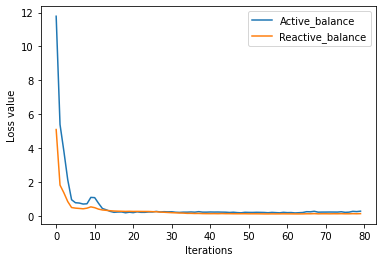

In [ ]:
plt.plot(pbalance_list[:])
plt.plot(qbalance_list[:])
plt.legend(['Active_balance','Reactive_balance'])
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()